In [1]:
import sys
import numpy as np
import os         

# for reading sound files.
from scipy.io import wavfile                          

# For training the neural network.
# Install pybrain. e.g. pip install pybrain.

from pybrain.datasets            import ClassificationDataSet
from pybrain.tools.shortcuts     import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules   import SoftmaxLayer
from pybrain.tools.xml.networkreader import NetworkReader
from pybrain.tools.xml.networkwriter import NetworkWriter

from pybrain.structure import FullConnection
from pybrain.structure import SigmoidLayer
from pybrain.structure import FeedForwardNetwork
from pybrain.structure import LinearLayer
from pybrain.structure import SoftmaxLayer
from pybrain.structure import TanhLayer

sq = lambda x: x*x

# A convenient time step.
deltaT = 0.2
lim1 = 5; lim2 = 305
noisy = 0.05   # We have a very clean speech sample!

def getData(fil):
  sampFreq, snd = wavfile.read(fil)
  snd = snd/2E15                         # put in range (-1,1)
  duration = snd.shape[0]/sampFreq
  numChunks = int(duration/deltaT)
  sizeChunk = int(len(snd)/numChunks)
  
  # Frequencies.
  freqs  = np.fft.rfftfreq(sizeChunk,deltaT)
  chunksF = []
  for lp in range(0,numChunks):    
    chunk = snd[lp*sizeChunk:(lp+1)*sizeChunk]      # get a chunk of speech.     
    chunksF.append(1E9*np.abs(np.fft.rfft(chunk)))  # take the fft,conveniently normalized.  

  mu = np.mean(chunksF)
  newMean = 0.
  ctr = 0
  for i in range(0,numChunks):
    for j in range(lim1,lim2):
      if abs(chunksF[i][j]) > noisy*mu:         # ignore silent portions.
        newMean += chunksF[i][j]
        ctr += 1

  # Delete portions of the sound file when the user is not speaking.
  mu = newMean/ctr
  zeros = []
  for lp in range(0,numChunks): 
    if np.mean(chunksF[lp]) < noisy*mu:  zeros.append(lp)

  data = []
  ctr = 0
  for i in range(0,numChunks):
    if i in zeros: continue         # silent part.
    tmp = []
    for j in range(lim1,lim2): tmp.append(chunksF[i][j])
    data.append(tmp)
  
  return data

def writeData(data,outFile):

  # Write the speech waveform to file, for plotting purposes.  
  l = len(data[0])
  f = open(outFile, "w")
  for i in range(0,len(data)):
    for j in range(0,l):
      f.write(str(i) + " " + str(j) + " " + str(data[i][j]) + "\n")
    f.write("\n")
  f.close()    


def getSamples(folders):

  # Each sound file is divided into a number of samples.
  samples = []
  for folder in folders:
    tmp = [v for v in os.listdir(folder) if v <> ".DS_Store"]
    samples.append(tmp)

  # Now samples[0] contains all the files for speaker 1,
  # samples[1] contains all the files for speaker 2, and so on.  
  speechSpeakers = []
  ctr = 0
  for sample in samples:
    speechSpeaker = []
    for file in sample:
      lsts = getData(folders[ctr]+file)
      for lst in lsts: speechSpeaker.append(lst)
    speechSpeakers.append(speechSpeaker)
    ctr += 1

  return speechSpeakers
      
def XY(speech,numFeatures,N):      
  
  tX = np.mat(np.zeros((N,numFeatures)))
  tY = []
  ctr = 0
  for i in range(0,len(speech)):
    for j in range(0,len(speech[i])):
      for k in range(0,numFeatures):
        tX[ctr,k] = speech[i][j][k]
      ctr += 1  
      tY.append(i)            
      
  return tX,tY
        

In [2]:
trainingFoldersList = [    "train_me/english/",
                           "train_me/german/",
                           "train_me/chinese/"
                        ]

tstFoldersList = [   "test_me/english/",
                     "test_me/german/",
                     "test_me/chinese/"
                   ]

numSpeakers = 3
speech = getSamples(trainingFoldersList)  

In [3]:
for i in range(0,3):
  print np.shape(speech[i])

(883, 300)
(1027, 300)
(945, 300)


In [4]:
N1 = 0; numFeatures = lim2-lim1
for idx in range(0,len(speech)):
  N1 += len(speech[idx])
trainX,trainY = XY(speech,numFeatures,N1)    

minArray = []; maxArray = []
for i in range(0,numFeatures):
  minArray.append(np.min(trainX[:,i]))
  maxArray.append(np.max(trainX[:,i]))    

f = open("min_max_values.dat", "w")
for i in range(0,numFeatures):
  f.write(str(maxArray[i]) + " " + str(minArray[i]) + "\n")
f.close()      
    
# Put training data in range (0,1)  
for i in range(0,N1):
  for j in range(0,numFeatures):
    trainX[i,j] = (trainX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  
       
speech = getSamples(tstFoldersList)
N2 = 0; 
for idx in range(0,len(speech)):
  N2 += len(speech[idx])
  
tstX,tstY = XY(speech,numFeatures,N2)
for i in range(0,N2):
  for j in range(0,numFeatures):
    tstX[i,j] = (tstX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  

trainLabels = np.mat(np.zeros((len(trainY),numSpeakers)))
tstLabels = np.mat(np.zeros((len(tstY),numSpeakers)))

for i in range(0,len(trainY)):
  for j in range(0,numSpeakers):
    if trainY[i] == j: trainLabels[i,j] = 1
    else: trainLabels[i,j] = 0

for i in range(0,len(tstY)):
  for j in range(0,numSpeakers):
    if tstY[i] == j: tstLabels[i,j] = 1
    else: tstLabels[i,j] = 0


In [5]:
# Test the classifier.
def tstClassifier(nn,tstX,tstY,ss):

  # Index corresponding to start of speaker 'n'
  limits = [0]  
  for lp in range(1,numSpeakers):
    for i in range(0,len(tstY)):
      if tstY[i] == lp:  break
    limits.append(i)
  limits.append(len(tstY))

  # Confusion matrix: Speaker 'm' predicted as speaker 'n'.
  confusion = np.mat(np.zeros((numSpeakers,numSpeakers)))  
  numS = {}
  answers = []  
  yes = 0; total = 0  
  step = ss
  for speaker in range(0,numSpeakers):
    for lp in range(limits[speaker],limits[speaker+1]-step,step):
      pred = []
      for x in range(lp,lp+step):
        A = [tstX[x,v] for v in range(0,numFeatures)]
        # Make a prediction.
        res = list(nn.activate(A))
        pred.append(res.index(np.max(res)))

      # There's a probability for every speaker. Let's pick the largest.  
      ctr = {}
      for v in pred:
        if v not in ctr: ctr[v] = 1
        else: ctr[v] += 1
      kys = ctr.keys()
      m = 0; best = 0
      for ky in kys:
        if ctr[ky] > m:
          m = ctr[ky]
          best = ky
    
      #Overall accuracy.
      if best == tstY[lp]: yes += 1
        
      # Confusion matrix. Speaker 'i' predicted to be speaker 'j'.  
      for r in range(0,numSpeakers):
        if tstY[lp] == r: 
          if r not in numS: numS[r] = 1
          else: numS[r] += 1   
        for c in range(0,numSpeakers):
          if tstY[lp] == r and best == c:
            confusion[r,c] += 1
          
      total += 1
    answers.append(yes*1./total)

  return answers,confusion,numS

In [6]:
#
# Now, we train the neural network.
#
numClasses = len(speech)
numHiddenNodes = 10     # Nodes per hidden layer.
numHiddenLayers = 5     # 5 layers.
possibleOutputs = 1     # Only 1 kind of output, i.e. each sample is one speaker.
numTrainingEpochs = 10  # Train 10 epochs.

trndata = ClassificationDataSet(numFeatures, possibleOutputs, nb_classes=numClasses)
ctr = 0
for row in range(0,N1):
  tempListOut = []; tempListIn = []
  tempListOut.append(int(trainY[row]))
  for i in range(0,numFeatures): 
    tempListIn.append(trainX[row,i])
    
  trndata.addSample(tempListIn,tempListOut)
trndata._convertToOneOfMany()

#first = True
first = False
outfolder = "networks_me/"    
nnFile = "nn89.xml" # Most recent.
st = 90

# For the first time, we need to create the neural network.
# After that, we just need to train.

if first:
  nn = FeedForwardNetwork()
  inputLayer = LinearLayer(numFeatures)
  nn.addInputModule(inputLayer)
  hiddenLayers = []
  for x in range(numHiddenLayers):
    hiddenLayer = SigmoidLayer(numHiddenNodes)
    nn.addModule(hiddenLayer)
    hiddenLayers.append(hiddenLayer)
  outputLayer = SoftmaxLayer(len(speech))
  nn.addOutputModule(outputLayer)
  
  inputConnection = FullConnection(inputLayer,hiddenLayers[0])
  outputConnection = FullConnection(hiddenLayers[numHiddenLayers-1],outputLayer)
  for x in range(numHiddenLayers-1):
    connect = FullConnection(hiddenLayers[x],hiddenLayers[x-1])
    nn.addConnection(connect)
  nn.addConnection(inputConnection)
  nn.addConnection(outputConnection)
  nn.sortModules()

else:  # We already have a network!
  nn = NetworkReader.readFrom(outfolder+nnFile)
    
trainer = BackpropTrainer(nn, dataset=trndata, momentum=0., verbose=True, weightdecay=0.)  
for i in range(numTrainingEpochs): 
  trainer.trainOnDataset(dataset=trndata)    
  if (i+1)%5 == 0:
    # Save the network, to save time.
    NetworkWriter.writeToFile(nn, outfolder+"nn" + str(st)+".xml")     
    st += 1
    print i+1

Total error: 0.0214488518858
Total error: 0.021570423828
Total error: 0.0214594749838
Total error: 0.0212664326675
Total error: 0.0214084629781
5
Total error: 0.0214082122357
Total error: 0.0212474208161
Total error: 0.0211137870154
Total error: 0.0210468451029
Total error: 0.020818566183
10


In [7]:
# Performance on the test set, as a function of training epoch.
# We stop when we see signs of overfitting.
# On 0.2 seconds of data.
X = []; Y = []
st = 1
for q in range(0,90):
  net = outfolder+"nn"+str(q)+".xml"
  nn = NetworkReader.readFrom(net)
  A,c,n = tstClassifier(nn,tstX,tstY,st)
  if q%5 == 0:
    print net,st*0.2,np.mean(A)
  X.append((q+1)*5)
  Y.append(np.mean(A))

networks_me/nn0.xml 0.2 0.280981179263
networks_me/nn5.xml 0.2 0.502620013646
networks_me/nn10.xml 0.2 0.513930620282
networks_me/nn15.xml 0.2 0.568091580819
networks_me/nn20.xml 0.2 0.60065910051
networks_me/nn25.xml 0.2 0.558942550837
networks_me/nn30.xml 0.2 0.532043504795
networks_me/nn35.xml 0.2 0.581865252131
networks_me/nn40.xml 0.2 0.583833075888
networks_me/nn45.xml 0.2 0.584162729559
networks_me/nn50.xml 0.2 0.599650551292
networks_me/nn55.xml 0.2 0.633341046949
networks_me/nn60.xml 0.2 0.569535633013
networks_me/nn65.xml 0.2 0.583219514913
networks_me/nn70.xml 0.2 0.58777900417
networks_me/nn75.xml 0.2 0.594066452924
networks_me/nn80.xml 0.2 0.59154517113
networks_me/nn85.xml 0.2 0.62028660342


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


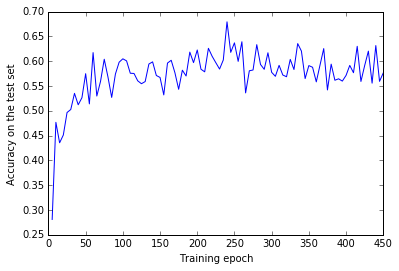

In [8]:
# Plot performance with training epoch, on 0.2 seconds of data.
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(X,Y)
plt.xlabel("Training epoch")
plt.ylabel("Accuracy on the test set")
plt.show()

In [9]:
# Performance on the test set, with 't' seconds of data,
# Accuracy for t = 0.2,0.4,0.6,0.8,1.0,... seconds.
net = "nn85.xml"
nn = NetworkReader.readFrom(outfolder+net)
X = []; Y = []
for st in range(1,21):
  A,c,n = tstClassifier(nn,tstX,tstY,st)
  print st*0.2,np.mean(A)
  X.append(st*0.2)
  Y.append(np.mean(A))

0.2 0.62028660342
0.4 0.718419433835
0.6 0.746423089756
0.8 0.755795795796
1.0 0.835362047441
1.2 0.847741074408
1.4 0.871592811937
1.6 0.904873054873
1.8 0.878238163952
2.0 0.955050505051
2.2 0.916361416361
2.4 0.976851851852
2.6 1.0
2.8 0.989247311828
3.0 1.0
3.2 1.0
3.4 1.0
3.6 1.0
3.8 1.0
4.0 1.0


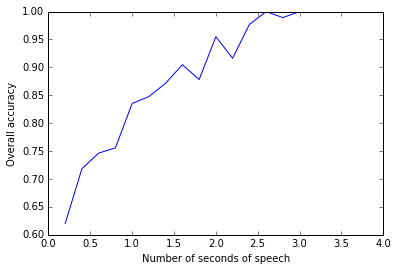

In [10]:
plt.plot(X,Y)
plt.xlabel("Number of seconds of speech")
plt.ylabel("Overall accuracy")
plt.show()

In [11]:
nn = NetworkReader.readFrom(outfolder+net)
for st in [1,5,10]:
  A,c,n = tstClassifier(nn,tstX,tstY,st)
  # Columns are predictions.
  # First row: Example 1(English): Number of samples predicted as Example 1,2,3
  # With 1 second of speech, Example 1 is identified 28/32 times, and wrongly predicted to be Example 2 4/32 times.
  # With 1 second of speech, Example 2 is identified 22/28 times, and wrongly predicted to be Example 1 6/28 times.        
  print "With " + str(st*0.2) + " second(s) of speech"
  print c
  print "\n"[:-1]

With 0.2 second(s) of speech
[[ 99.  39.  24.]
 [ 36.  89.  15.]
 [ 32.  21.  93.]]

With 1.0 second(s) of speech
[[ 28.   4.   0.]
 [  6.  22.   0.]
 [  5.   3.  21.]]

With 2.0 second(s) of speech
[[ 16.   0.   0.]
 [  2.  12.   0.]
 [  1.   0.  13.]]



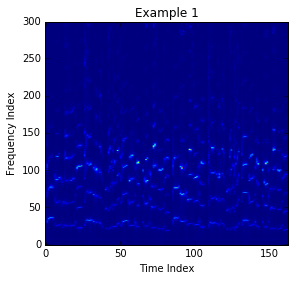

In [12]:
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.title("Example 1")
plt.imshow(np.matrix(speech[0]).T,origin="lower",aspect=0.5)

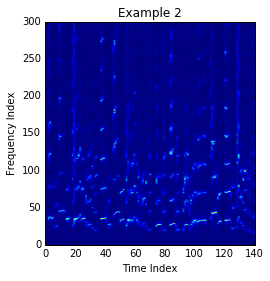

In [13]:
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.title("Example 2")
plt.imshow(np.matrix(speech[1]).T,origin="lower",aspect=0.5)

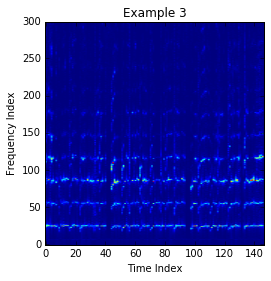

In [14]:
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.title("Example 3")
plt.imshow(np.matrix(speech[2]).T,origin="lower",aspect=0.5)